# Bone X-Ray abnormality detection <br>

Dataset : [MURA (musculoskeletal radiographs)](https://stanfordmlgroup.github.io/competitions/mura/)<br>

>__<font color=darkturquoise>Deep Learning Project 2</font>__<br>
>__<font color=darkturquoise>Myriam Sarantea P3351818</font>__<br>

ATHENS UNIVERSITY OF ECONOMICS & BUSINESS <br>
M.Sc. in Data Science <br>
Part Time 2018-2020

In [1]:
import gc
import pandas as pd
import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import random
from numpy.random import seed
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score

%matplotlib inline

# Set maximum width in characters of a column in pandas
pd.set_option('display.max_colwidth', 100)

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
from glob import glob

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D, AveragePooling2D, Activation, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate # Layers to be used for building our model
from tensorflow.keras.models import Model, load_model # The class used to create a model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras import losses, optimizers, activations, metrics
#from tensorflow.random import set_seed
import tensorflow_hub as hub


print("Tensorflow version " + tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if len(tf.config.list_physical_devices('GPU'))>0 else "NOT AVAILABLE")

Tensorflow version 2.1.1
Hub version: 0.8.0
GPU is available


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
import keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11488146316881128985
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1444338073
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6200401804063931766
physical_device_desc: "device: 0, name: GeForce MX130, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


Using TensorFlow backend.


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
random.seed(1990)
seed(1990)
tf.random.set_seed(1990)

### Read MURA Datataset

In [4]:
PATH = 'MURA-v1.1/'

In [5]:
# Read Image paths from files
train_image_paths = pd.read_csv(PATH+'train_image_paths.csv', names=['ImagePath'])
test_image_paths = pd.read_csv(PATH+'valid_image_paths.csv', names=['ImagePath'])

# Read Study paths and Study classes from files
train_labeled_studies = pd.read_csv(PATH+'train_labeled_studies.csv', names=['StudyPath', 'Class'])
test_labeled_studies = pd.read_csv(PATH+'valid_labeled_studies.csv', names=['StudyPath', 'Class'])

In [6]:
# Create Dataframes with Image path (ImagePath), Type of Study (Type), Study Number (Study),
# Patient Number (Patient) and Class

# Training Set

train_labeled_studies['Type'] = train_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[2][3:])
train_labeled_studies['Patient'] = train_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[3][7:])
train_labeled_studies['Study'] = train_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[4][:6])

train_image_paths['StudyPath'] = train_image_paths['ImagePath'].apply(lambda x: x.rpartition('/')[0]+'/')
train_image_paths['Image'] = train_image_paths['ImagePath'].apply(lambda x: x.rpartition('/')[2])

train_labeled_images = train_labeled_studies.merge(train_image_paths, how='inner', on='StudyPath')
train_labeled_images = train_labeled_images.drop(columns=['StudyPath'])
train_labeled_images['Class'] = train_labeled_images['Class'].apply(str)

# Test Set

test_labeled_studies['Type'] = test_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[2][3:])
test_labeled_studies['Patient'] = test_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[3][7:])
test_labeled_studies['Study'] = test_labeled_studies['StudyPath'].apply(lambda x: x.split('/')[4][:6])

test_image_paths['StudyPath'] = test_image_paths['ImagePath'].apply(lambda x: x.rpartition('/')[0]+'/')
test_image_paths['Image'] = test_image_paths['ImagePath'].apply(lambda x: x.rpartition('/')[2])

test_labeled_images = test_labeled_studies.merge(test_image_paths, how='inner', on='StudyPath')
test_labeled_images = test_labeled_images.drop(columns=['StudyPath'])
test_labeled_images['Class'] = test_labeled_images['Class'].apply(str)

In [7]:
# Delete unwanted Dataframes

del [[train_image_paths, test_image_paths, train_labeled_studies, test_labeled_studies]]
gc.collect()

42

In [8]:
# print Training Set
train_labeled_images

,Class,Type,Patient,Study,ImagePath,Image
0,1,SHOULDER,00001,study1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,image1.png
1,1,SHOULDER,00001,study1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,image2.png
2,1,SHOULDER,00001,study1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,image3.png
3,1,SHOULDER,00002,study1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,image1.png
4,1,SHOULDER,00002,study1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,image2.png
...,...,...,...,...,...,...
36803,0,HAND,11183,study1,MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png,image2.png
36804,0,HAND,11183,study1,MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png,image3.png
36805,0,HAND,11184,study1,MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png,image1.png
36806,0,HAND,11184,study1,MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png,image2.png


In [9]:
# print Test Set
test_labeled_images

,Class,Type,Patient,Study,ImagePath,Image
0,1,WRIST,11185,study1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,image1.png
1,1,WRIST,11185,study1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,image2.png
2,1,WRIST,11185,study1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,image3.png
3,1,WRIST,11185,study1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,image4.png
4,1,WRIST,11186,study1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,image1.png
...,...,...,...,...,...,...
3192,0,FINGER,11967,study1,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,image3.png
3193,0,FINGER,11967,study1,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,image4.png
3194,0,FINGER,11738,study1,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,image1.png
3195,0,FINGER,11738,study1,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,image2.png


## Data Exploration

In [10]:
total_train_img = len(train_labeled_images)
total_test_img = len(test_labeled_images)
print("Number of Training images: ", total_train_img)
print("Number of Test images: ", total_test_img)

Number of Training images:  36808
Number of Test images:  3197


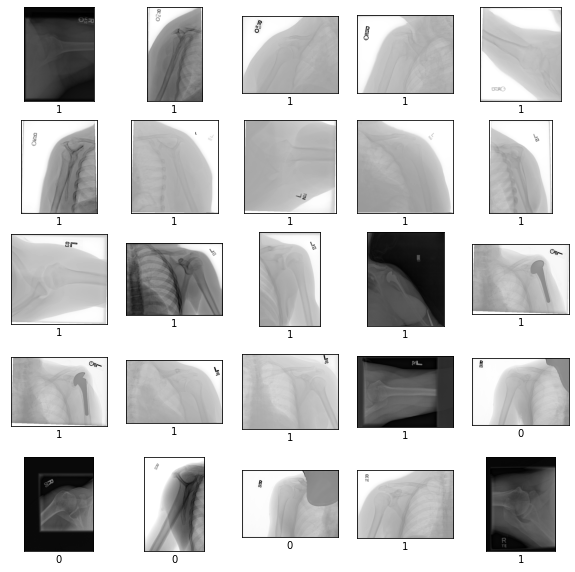

In [11]:
# Image Examples

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Image.open(train_labeled_images['ImagePath'][i]), cmap=plt.cm.binary)
    plt.xlabel(train_labeled_images['Class'][i])
plt.show()

### Training Set

In [12]:
print('\033[1m' + "Images per Class (actual values):\n" + '\033[0m')
series = train_labeled_images[['Class', 'ImagePath']].groupby(['Class']).size()
print(series,'\n')
print('\033[1m' + "Images per Class (percentages):\n" + '\033[0m')
print(round(series/total_train_img*100, 1),'\n')
print('\033[1m' + "Images per Type of Study (actual values):\n" + '\033[0m')
series = train_labeled_images[['ImagePath', 'Type']].groupby(['Type']).size()
print(series,'\n')
print('\033[1m' + "Images per Type of Study (percentages):\n" + '\033[0m')
print((round(series/total_train_img*100, 1)),'\n')
print('\033[1m' + "Images per Type of Study and Class (actual values):\n" + '\033[0m')
series = train_labeled_images[['ImagePath', 'Type', 'Class']].groupby(['Type', 'Class']).size()
print(series,'\n')
print('\033[1m' + "Images per Type of Study and Class (percentages):\n" + '\033[0m')
print((round(series/total_train_img*100, 1)),'\n')

Images per Class (actual values):

Class
0    21935
1    14873
dtype: int64 

Images per Class (percentages):

Class
0    59.6
1    40.4
dtype: float64 

Images per Type of Study (actual values):

Type
ELBOW       4931
FINGER      5106
FOREARM     1825
HAND        5543
HUMERUS     1272
SHOULDER    8379
WRIST       9752
dtype: int64 

Images per Type of Study (percentages):

Type
ELBOW       13.4
FINGER      13.9
FOREARM      5.0
HAND        15.1
HUMERUS      3.5
SHOULDER    22.8
WRIST       26.5
dtype: float64 

Images per Type of Study and Class (actual values):

Type      Class
ELBOW     0        2925
          1        2006
FINGER    0        3138
          1        1968
FOREARM   0        1164
          1         661
HAND      0        4059
          1        1484
HUMERUS   0         673
          1         599
SHOULDER  0        4211
          1        4168
WRIST     0        5765
          1        3987
dtype: int64 

Images per Type of Study and Class (percentages):

Type      C

### Test Set

In [13]:
print('\033[1m' + "Images per Class (actual values):\n" + '\033[0m')
series = test_labeled_images[['Class', 'ImagePath']].groupby(['Class']).size()
print(series,'\n')
print('\033[1m' + "Images per Class (percentages):\n" + '\033[0m')
print(round(series/total_test_img*100, 1),'\n')
print('\033[1m' + "Images per Type of Study (actual values):\n" + '\033[0m')
series = test_labeled_images[['ImagePath', 'Type']].groupby(['Type']).size()
print(series,'\n')
print('\033[1m' + "Images per Type of Study (percentages):\n" + '\033[0m')
print((round(series/total_test_img*100, 1)),'\n')
print('\033[1m' + "Images per Type of Study and Class (actual values):\n" + '\033[0m')
series = test_labeled_images[['ImagePath', 'Type', 'Class']].groupby(['Type', 'Class']).size()
print(series,'\n')
print('\033[1m' + "Images per Type of Study and Class (percentages):\n" + '\033[0m')
print((round(series/total_test_img*100, 1)),'\n')

Images per Class (actual values):

Class
0    1667
1    1530
dtype: int64 

Images per Class (percentages):

Class
0    52.1
1    47.9
dtype: float64 

Images per Type of Study (actual values):

Type
ELBOW       465
FINGER      461
FOREARM     301
HAND        460
HUMERUS     288
SHOULDER    563
WRIST       659
dtype: int64 

Images per Type of Study (percentages):

Type
ELBOW       14.5
FINGER      14.4
FOREARM      9.4
HAND        14.4
HUMERUS      9.0
SHOULDER    17.6
WRIST       20.6
dtype: float64 

Images per Type of Study and Class (actual values):

Type      Class
ELBOW     0        235
          1        230
FINGER    0        214
          1        247
FOREARM   0        150
          1        151
HAND      0        271
          1        189
HUMERUS   0        148
          1        140
SHOULDER  0        285
          1        278
WRIST     0        364
          1        295
dtype: int64 

Images per Type of Study and Class (percentages):

Type      Class
ELBOW     0       

In [14]:
del [[series]]
gc.collect()

37459

### Data Preprocessing

* Shuffle Images
* Convert to square
* Standarization
* Global Contrast Normalization
* Data Augmentation
    * Rotation
    * Flipping
    * Noise

In [15]:
# Shuffle training and test dataframes

train_labeled_images = train_labeled_images.sample(frac=1).reset_index(drop=True)
test_labeled_images = test_labeled_images.sample(frac=1).reset_index(drop=True)

In [16]:
# Choose aspect ration for rescaling

scale = []
for i in range(len(train_labeled_images)):
    img = Image.open(train_labeled_images.iloc[i, train_labeled_images.columns.get_loc('ImagePath')])
    (x,y) = img.size
    scale.append(round(x/y, 2))
# print(scale)  

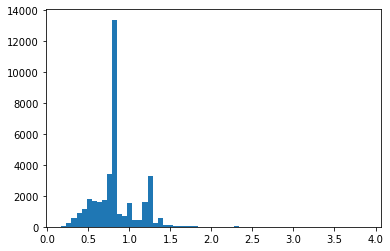

In [17]:
(n, bins, patches) = plt.hist(scale, bins=60, label='hst')
plt.show()
# print(np.rint(n).astype(int))

In [16]:
x = 224
y = round(x/0.83)
print("For this reason we choose to reshape images into shape (height, width) : (%d,%d)" %(y,x))

For this reason we choose to reshape images into shape (height, width) : (270,224)


In method flow_from_dataframe() of tf.keras.preprocessing.image.ImageDataGenerator, the target_size is a tuple of integers `(height, width)`with default: (256, 256). Is the dimensions to which all images found will be resized.
The size() method of Pillow, returns `(width, height)`. That's why we change the x and y.

In [17]:
SIZE = (270, 224)
INPUT_SHAPE = (270, 224, 3)

### Generate batches of tensor image data with real-time data augmentation.

In [18]:
def enhance_image(img):
    init_image = Image.fromarray((img * 255).astype(np.uint8))
    eh1 = ImageEnhance.Contrast(init_image)
    im1 = eh1.enhance(1.2)
    eh2 = ImageEnhance.Sharpness(im1)
    im2 = eh2.enhance(1.2)
    eh3 = ImageEnhance.Brightness(im2)
    im3 = eh3.enhance(1.2)
    final_img = img_to_array(im3) / 255.0
    return final_img

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
#     vertical_flip=True,
    rotation_range=90,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
    fill_mode='nearest',
#     preprocessing_function = preprocess_input,
    validation_split=0.20)

In [20]:
test_datagen = ImageDataGenerator(
    rescale=1./255.,
    fill_mode='nearest')
#     preprocessing_function = preprocess_input)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labeled_images,
        directory = None,
        x_col = "ImagePath",
        y_col = "Class",
        subset = "training",
        batch_size = 32,
        seed = 42,
        shuffle = False,
        class_mode = "binary",
        target_size = SIZE)

Found 29447 validated image filenames belonging to 2 classes.


In [22]:
valid_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labeled_images,
        directory = None,
        x_col = "ImagePath",
        y_col = "Class",
        subset = "validation",
        batch_size = 32,
        seed = 42,
        shuffle = False,
        class_mode = "binary",
        target_size = SIZE)

Found 7361 validated image filenames belonging to 2 classes.


In [23]:
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_labeled_images,
        directory = None,
        x_col = "ImagePath",
        y_col = "Class",
        batch_size = 23,
        seed = 42,
        shuffle = False,
        class_mode = "binary",
        target_size = SIZE)

Found 3197 validated image filenames belonging to 2 classes.


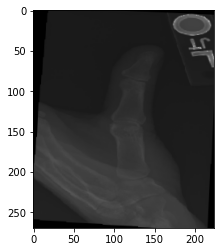

In [26]:
# Example of plotting image using image generator

plt.imshow((train_generator[0][0][9] * 255).astype(np.uint8))

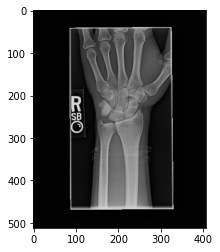

In [27]:
# Example of plotting image from source

img = Image.open(train_labeled_images['ImagePath'][5])
plt.imshow(img)

## Define Methods for Plots and Classification Results

In [24]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'AUC')
    plt.legend()
    plt.show()

In [25]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [26]:
# We choose depending on the majority prediction of the images
def majority_rules(lst):
    return round(sum(np.rint(lst)) / len(lst))

# If a prediction is very certain and over a threshold, then this is the dominant prediction,
# or else the majority wins
def majority_threshold(lst):
    threshold = 0.85
    if max(lst) >= threshold:
        return 1
    else:
        return majority_rules(lst)
    
# We choose depending on the mean of all images predictions
def simple_mean(lst):
    return round(np.mean(lst))

# If a prediction is very certain and over a threshold, then this is the dominant prediction,
# or else we take the average prediction
def mean_threshold(lst):
    threshold = 0.85
    if max(lst) >= threshold:
        return 1
    else:
        return simple_mean(lst)

In [27]:
def get_model_results(predictions):

    predictions = predictions.flatten()
    
    # Add image paths, classes and predictions into dataframe
    imagepaths = test_generator.filenames
    true_classes = test_generator.classes
    model_results = pd.DataFrame({"ImagePath":imagepaths,
                                  "True_Class":true_classes,
                                  "Predictions_Probs":predictions})
    
    # Print dataframe
    # model_results.head(10)
    
    # Check Labels
    labels = (test_generator.class_indices)
    print("\nClass Labels: ", labels, "\n")
    
    # Get Type, Patient and Study in results dataframe
    model_results['Key'] = model_results['ImagePath'].apply(lambda x: x.split('/')[2][3:]) + '|' + model_results['ImagePath'].apply(lambda x: x.split('/')[3][7:]).map(str) + '|' + model_results['ImagePath'].apply(lambda x: x.split('/')[4][:6])
    model_results = model_results.drop(columns=['ImagePath'])
    # model_results.head(10)
    
    # Group by Key and append values in list
    model_results_per_study = model_results.groupby('Key')[['True_Class','Predictions_Probs']].agg(list).reset_index()
    model_results_per_study.head(10)
    
    # Keep True class
    model_results_per_study['True_Class'] = model_results_per_study['True_Class'].apply(lambda x: max(x))
    
    # Calculate prediction for each study, depending on the voting sheme
    model_results_per_study['Pred_Majority'] = model_results_per_study['Predictions_Probs'].apply(lambda x: majority_rules(x))
    model_results_per_study['Pred_Majority_Thr'] = model_results_per_study['Predictions_Probs'].apply(lambda x: majority_threshold(x))
    model_results_per_study['Pred_Mean'] = model_results_per_study['Predictions_Probs'].apply(lambda x: simple_mean(x))
    model_results_per_study['Pred_Mean_Thr'] = model_results_per_study['Predictions_Probs'].apply(lambda x: mean_threshold(x))
#     model_results_per_study.head(15)
    
    # Classification report for majority_rules
    y_actual = model_results_per_study['True_Class'].to_numpy()
    y_predic = model_results_per_study['Pred_Majority'].to_numpy()
    print('\033[1m' + "Classification Report (majority_rules):\n" + '\033[0m')
    print(classification_report(y_actual, y_predic, target_names=['Negative (0)','Positive (1)']), "\n")
    print('\033[1m' + "Confusion Matrix (majority_rules):\n" + '\033[0m')
    print(confusion_matrix(y_actual, y_predic), "\n")
    print('Kappa score: ' + str(cohen_kappa_score(y_actual, y_predic)), "\n")
       
    # Classification report for majority_threshold
    y_actual = model_results_per_study['True_Class'].to_numpy()
    y_predic = model_results_per_study['Pred_Majority_Thr'].to_numpy()
    print('\033[1m' + "Classification Report (majority_threshold):\n" + '\033[0m')
    print(classification_report(y_actual, y_predic, target_names=['Negative (0)','Positive (1)']), "\n")
    print('\033[1m' + "Confusion Matrix (majority_threshold):\n" + '\033[0m')
    print(confusion_matrix(y_actual, y_predic), "\n")
    print('Kappa score: ' + str(cohen_kappa_score(y_actual, y_predic)), "\n")
    
    # Classification report for simple_mean
    y_actual = model_results_per_study['True_Class'].to_numpy()
    y_predic = model_results_per_study['Pred_Mean'].to_numpy()
    print('\033[1m' + "Classification Report (averaging):\n" + '\033[0m')
    print(classification_report(y_actual, y_predic, target_names=['Negative (0)','Positive (1)']), "\n")
    print('\033[1m' + "Confusion Matrix (averaging):\n" + '\033[0m')
    print(confusion_matrix(y_actual, y_predic), "\n")
    print('Kappa score: ' + str(cohen_kappa_score(y_actual, y_predic)), "\n")

    # Classification report for mean_threshold
    y_actual = model_results_per_study['True_Class'].to_numpy()
    y_predic = model_results_per_study['Pred_Mean_Thr'].to_numpy()
    print('\033[1m' + "Classification Report (averaging with threshold):\n" + '\033[0m')
    print(classification_report(y_actual, y_predic, target_names=['Negative (0)','Positive (1)']), "\n")
    print('\033[1m' + "Confusion Matrix (averaging with threshold):\n" + '\033[0m')
    print(confusion_matrix(y_actual, y_predic), "\n")
    print('Kappa score: ' + str(cohen_kappa_score(y_actual, y_predic)), "\n")
    
    return(model_results_per_study)

In [28]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

## CNN Baseline

In [33]:
def train_model(
        optimizer,
        epochs=100,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='sigmoid',
        callbacks=None,
        verbose=0):
    
    np.random.seed(1990) # Define the seed for numpy to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.3,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[AUC(name='auc'), 'binary_accuracy'])
    
    hs = model.fit(
        x=train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
    )
    
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

In [36]:
input_shape = INPUT_SHAPE
classes = 1

# Choose epochs
epochs = 100

# Using Adam
optimizer = RMSprop(learning_rate=0.01, momentum=0.1)
#, clipvalue=5.0
# optimizer = RMSprop(learning_rate=0.1, momentum=0.1)

input_shape = INPUT_SHAPE


early_stop = ReturnBestEarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=4,
    cooldown=4,
    verbose=1
)

            
# 5 Convolutional Layers and Adam optimizer
conv_model_1, conv_model_1_hs = train_model(
    optimizer=optimizer,
    epochs=epochs,
    conv_layers=5,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='sigmoid',
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 921 steps, validate for 231 steps
Epoch 1/100
921/921 [==============================] - 502s 545ms/step - loss: 0.7026 - auc: 0.4966 - binary_accuracy: 0.5943 - val_loss: 0.6725 - val_auc: 0.5000 - val_binary_accuracy: 0.6010
Epoch 2/100
921/921 [==============================] - 494s 537ms/step - loss: 0.6752 - auc: 0.5005 - binary_accuracy: 0.5947 - val_loss: 0.6727 - val_auc: 0.5000 - val_binary_accuracy: 0.6010
Epoch 3/100
921/921 [==============================] - 496s 539ms/step - loss: 0.6754 - auc: 0.4933 - binary_accuracy: 0.5947 - val_loss: 0.6720 - val_auc: 0.5000 - val_binary_accuracy: 0.6010
Epoch 4/100
921/921 [==============================] - 496s 538ms/step - loss: 0.6753 - auc: 0.4969 - binary_accuracy: 0.5947 - val_loss: 0.6723 - val_auc: 0.5000 - val_binary_accuracy: 0.6010
Epoch 5/100
921/921 [==============================] - 495s 537ms/step - loss: 0.6752 - auc: 0.5015 - binary_accuracy: 0.5947 - val_lo

In [37]:
# Evaluate on test data and show all the results.
conv_model_1_eval = conv_model_1.evaluate(x=test_generator, verbose=1)

  ...
    to  
  ['...']
139/139 [==============================] - 15s 106ms/step - loss: 0.7042 - auc: 0.5000 - binary_accuracy: 0.5214


Train Loss     : 0.67513
Validation Loss: 0.67201
Test Loss      : 0.70422
---
Train AUC     : 0.50000
Validation AUC: 0.50000
Test AUC      : 0.50000



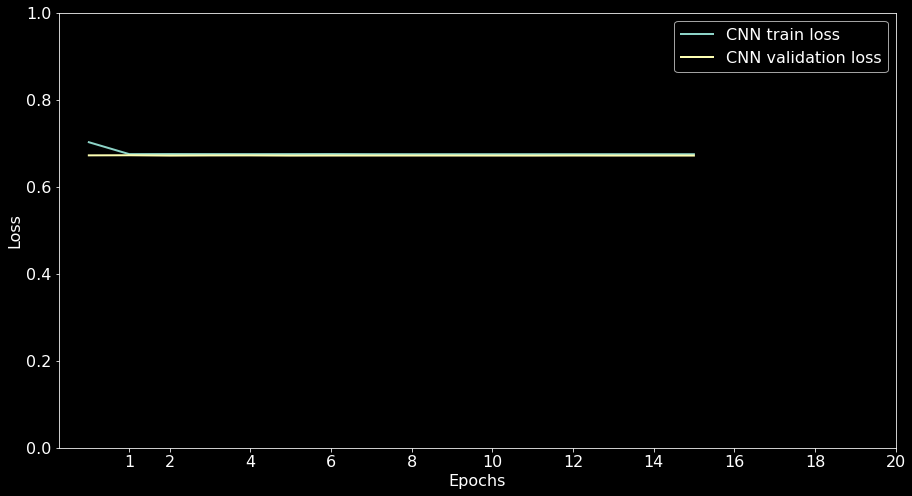

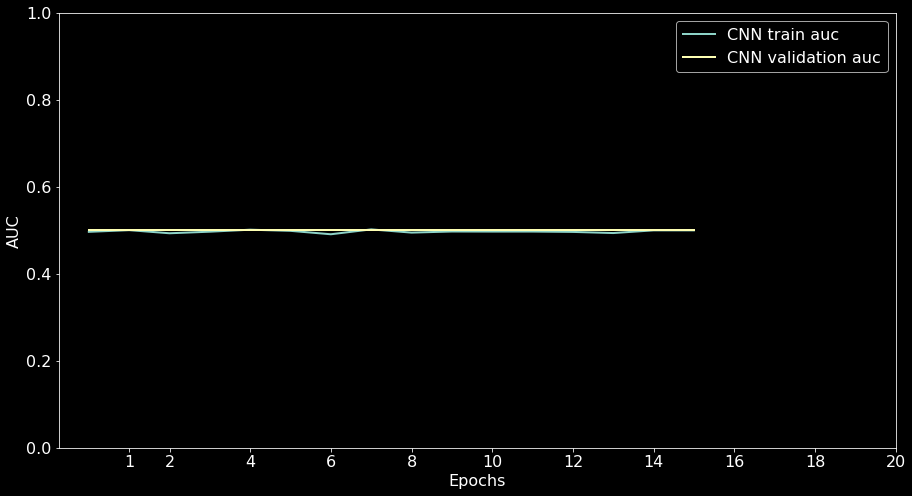

In [38]:
print("Train Loss     : {0:.5f}".format(conv_model_1_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_model_1_hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_model_1_eval[0]))
print("---")
print("Train AUC     : {0:.5f}".format(conv_model_1_hs.history['auc'][-1]))
print("Validation AUC: {0:.5f}".format(conv_model_1_hs.history['val_auc'][-1]))
print("Test AUC      : {0:.5f}".format(conv_model_1_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'CNN': conv_model_1_hs}, epochs=20, metric='loss')
plot_history(hs={'CNN': conv_model_1_hs}, epochs=20, metric='auc')
# plot_history(hs={'Conv No Drop': conv_model_1_hs}, epochs=epochs, metric='binary_accuracy')

In [39]:
# Predict class probabilities on test set
test_generator.reset()
predictions_conv_model_1 = conv_model_1.predict(test_generator, verbose=1)

139/139 [==============================] - 10s 72ms/step


In [40]:
# Get Classification Results
df_results_conv_model_1 = get_model_results(predictions_conv_model_1)


Class Labels:  {'0': 0, '1': 1} 

Classification Report (majority_rules):

              precision    recall  f1-score   support

Negative (0)       0.55      1.00      0.71       661
Positive (1)       0.00      0.00      0.00       538

    accuracy                           0.55      1199
   macro avg       0.28      0.50      0.36      1199
weighted avg       0.30      0.55      0.39      1199
 

Confusion Matrix (majority_rules):

[[661   0]
 [538   0]] 

Kappa score: 0.0 

Classification Report (majority_threshold):

              precision    recall  f1-score   support

Negative (0)       0.55      1.00      0.71       661
Positive (1)       0.00      0.00      0.00       538

    accuracy                           0.55      1199
   macro avg       0.28      0.50      0.36      1199
weighted avg       0.30      0.55      0.39      1199
 

Confusion Matrix (majority_threshold):

[[661   0]
 [538   0]] 

Kappa score: 0.0 

Classification Report (averaging):

              precisi

c:\users\myriam.sarantea\pycharmprojects\mura\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# # Clean up model from memory
# clean_up(conv_model_1)

### DenseNet 1

In [48]:
# Change Batch Size because of OOM errors
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labeled_images,
        directory = None,
        x_col = "ImagePath",
        y_col = "Class",
        subset = "training",
        batch_size = 4,
        seed = 42,
        shuffle = False,
        class_mode = "binary",
        target_size = SIZE)

Found 29447 validated image filenames belonging to 2 classes.


In [49]:
# Change Batch Size
valid_generator = train_datagen.flow_from_dataframe(
        dataframe=train_labeled_images,
        directory = None,
        x_col = "ImagePath",
        y_col = "Class",
        subset = "validation",
        batch_size = 4,
        seed = 42,
        shuffle = False,
        class_mode = "binary",
        target_size = SIZE)

Found 7361 validated image filenames belonging to 2 classes.


In [30]:
base_model=DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

out0 = base_model.output

out1 = GlobalMaxPooling2D()(out0)
out2 = GlobalAveragePooling2D()(out0)
out3 = Flatten()(out0)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)

predictions = Dense(1, activation="sigmoid")(out)

model1 = Model(inputs=base_model.input, outputs=predictions)

for layer in model1.layers[:-6]:
    layer.trainable=False

for layer in model1.layers[-6:]:
    layer.trainable=True

model1.compile(optimizer= Adam(lr=0.0001, clipvalue=5.0), loss='binary_crossentropy', metrics=[AUC(name='auc'), 'binary_accuracy'])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 270, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 276, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 135, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 135, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv5_block30_1_conv (Conv2D)   (None, 8, 7, 128)    233472      conv5_block30_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block30_1_bn (BatchNormal (None, 8, 7, 128)    512         conv5_block30_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block30_1_relu (Activatio (None, 8, 7, 128)    0           conv5_block30_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block30_2_conv (Conv2D)   (None, 8, 7, 32)     36864       conv5_block30_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block30_concat (Concatena (None, 8, 7, 1856)   0           conv5_block29_concat[0][0]       
                                                                 conv5_block30_2_conv[0][0]       
__________

In [31]:
# Using Adam
optimizer = Adam(lr=0.0001, clipvalue=5.0)
# optimizer = RMSprop(learning_rate=0.1, momentum=0.1)

input_shape = INPUT_SHAPE

early_stop = ReturnBestEarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=8,
    restore_best_weights=True,
    verbose=1
)
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.1,
    patience=3,
    cooldown=3,
    verbose=1
)


callbacks_list = [early_stop, reduce_lr]

In [ ]:
# Fits-the-model
history1 = model1.fit(
               x=train_generator,
               validation_data=valid_generator,
               epochs=70,
               verbose=1,
               callbacks=callbacks_list
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 921 steps, validate for 231 steps
Epoch 1/70
335/921 [=========>....................] - ETA: 15:29 - loss: 0.7908 - auc: 0.6394 - binary_accuracy: 0.6210

In [53]:
# Evaluate on test data and show all the results.
model1_eval = model1.evaluate(x=test_generator, verbose=1)

  ...
    to  
  ['...']
139/139 [==============================] - 114s 819ms/step - loss: 0.7107 - auc: 0.7698 - binary_accuracy: 0.7047


Train Loss     : 0.68898
Validation Loss: 0.55919
Test Loss      : 0.71066
---
Train AUC     : 0.75885
Validation AUC: 0.79969
Test AUC      : 0.76978



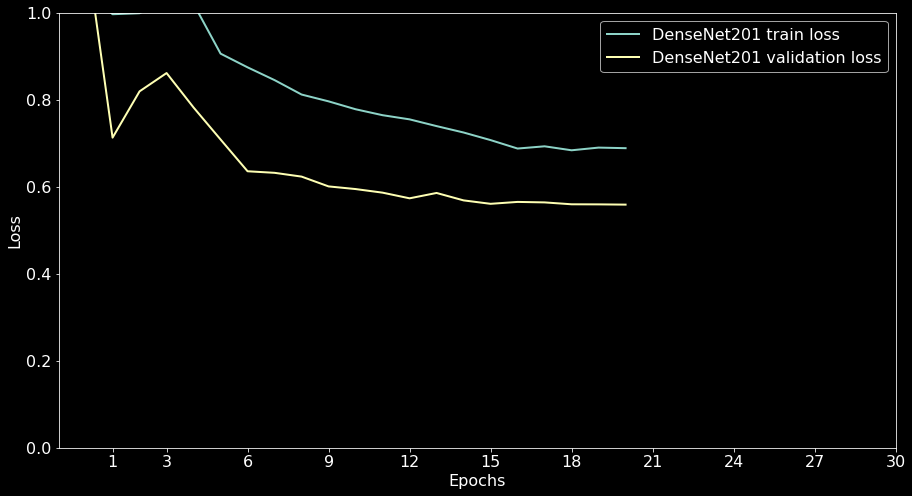

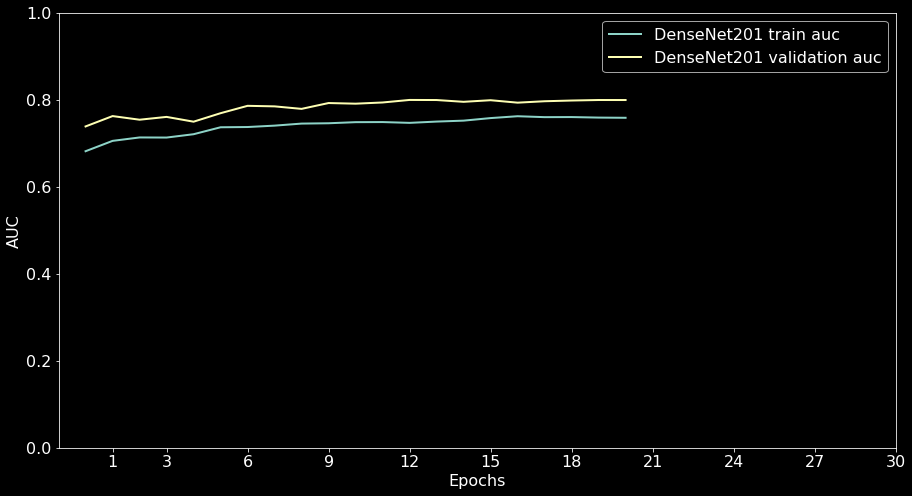

In [121]:
print("Train Loss     : {0:.5f}".format(history1.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history1.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(model1_eval[0]))
print("---")
print("Train AUC     : {0:.5f}".format(history1.history['auc'][-1]))
print("Validation AUC: {0:.5f}".format(history1.history['val_auc'][-1]))
print("Test AUC      : {0:.5f}".format(model1_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'DenseNet201': history1}, epochs=30, metric='loss')
plot_history(hs={'DenseNet201': history1}, epochs=30, metric='auc')

In [55]:
# Predict class probabilities on test set
test_generator.reset()
predictions_model1 = model1.predict(test_generator, verbose=1)

139/139 [==============================] - 107s 773ms/step


In [118]:
# Get Classification Results
df_results_model1 = get_model_results(predictions_model1)


Class Labels:  {'0': 0, '1': 1} 

Classification Report (majority_rules):

              precision    recall  f1-score   support

Negative (0)       0.69      0.92      0.79       661
Positive (1)       0.84      0.48      0.61       538

    accuracy                           0.72      1199
   macro avg       0.76      0.70      0.70      1199
weighted avg       0.75      0.72      0.71      1199
 

Confusion Matrix (majority_rules):

[[610  51]
 [279 259]] 

Kappa score: 0.4208509467323973 

Classification Report (majority_threshold):

              precision    recall  f1-score   support

Negative (0)       0.72      0.89      0.80       661
Positive (1)       0.81      0.57      0.67       538

    accuracy                           0.75      1199
   macro avg       0.77      0.73      0.74      1199
weighted avg       0.76      0.75      0.74      1199
 

Confusion Matrix (majority_threshold):

[[591  70]
 [230 308]] 

Kappa score: 0.4798685862027081 

Classification Report (aver

In [57]:
# clean_up(model1)

### DenseNet 2

In [58]:
base_model=DenseNet169(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) 

x=base_model.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

predictions=Dense(1,activation='sigmoid')(x)

model2=Model(inputs=base_model.input, outputs=predictions)

for layer in model2.layers[:-8]:
    layer.trainable=False
    
for layer in model2.layers[-8:]:
    layer.trainable=True


model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC(name='auc'), 'binary_accuracy'])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 270, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 276, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 135, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 135, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [59]:
# Using Adam
optimizer = Adam(lr=0.001, clipvalue=5.0)
# optimizer = RMSprop(learning_rate=0.1, momentum=0.1)

input_shape = INPUT_SHAPE

early_stop = ReturnBestEarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=8,
    restore_best_weights=True,
    verbose=1
)
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.1,
    patience=3,
    cooldown=3,
    verbose=1
)


callbacks_list = [early_stop, reduce_lr]

In [60]:
# Fits-the-model
history2 = model2.fit(
               x=train_generator,
               validation_data=valid_generator,
               epochs=70,
               verbose=1,
               callbacks=callbacks_list
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7362 steps, validate for 1841 steps
Epoch 1/70
7362/7362 [==============================] - 1227s 167ms/step - loss: 0.7577 - auc: 0.6158 - binary_accuracy: 0.6008 - val_loss: 0.5891 - val_auc: 0.7367 - val_binary_accuracy: 0.6991
Epoch 2/70
7362/7362 [==============================] - 1215s 165ms/step - loss: 0.6528 - auc: 0.6615 - binary_accuracy: 0.6394 - val_loss: 0.5728 - val_auc: 0.7513 - val_binary_accuracy: 0.7093
Epoch 3/70
7362/7362 [==============================] - 1214s 165ms/step - loss: 0.6224 - auc: 0.6873 - binary_accuracy: 0.6583 - val_loss: 0.5733 - val_auc: 0.7588 - val_binary_accuracy: 0.7044
Epoch 4/70
7362/7362 [==============================] - 1215s 165ms/step - loss: 0.6138 - auc: 0.6982 - binary_accuracy: 0.6670 - val_loss: 0.5578 - val_auc: 0.7684 - val_binary_accuracy: 0.7222
Epoch 5/70
7362/7362 [==============================] - 1215s 165ms/step - loss: 0.6079 - auc: 0.7054 - binary_accuracy: 0.6

Epoch 39/70
7362/7362 [==============================] - 1226s 167ms/step - loss: 0.5757 - auc: 0.7470 - binary_accuracy: 0.7030 - val_loss: 0.5185 - val_auc: 0.8074 - val_binary_accuracy: 0.7506
Epoch 40/70
7362/7362 [==============================] - 1222s 166ms/step - loss: 0.5758 - auc: 0.7468 - binary_accuracy: 0.7029 - val_loss: 0.5235 - val_auc: 0.8038 - val_binary_accuracy: 0.7506
Epoch 41/70
7362/7362 [==============================] - 1221s 166ms/step - loss: 0.5758 - auc: 0.7464 - binary_accuracy: 0.7002 - val_loss: 0.5250 - val_auc: 0.8039 - val_binary_accuracy: 0.7507
Epoch 42/70
7361/7362 [============================>.] - ETA: 0s - loss: 0.5737 - auc: 0.7494 - binary_accuracy: 0.7033
Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
7362/7362 [==============================] - 1217s 165ms/step - loss: 0.5737 - auc: 0.7494 - binary_accuracy: 0.7033 - val_loss: 0.5253 - val_auc: 0.8039 - val_binary_accuracy: 0.7564
Epoch 43/70
7362/7362 [====

In [61]:
# Evaluate on test data and show all the results.
model2_eval = model2.evaluate(x=test_generator, verbose=1)

  ...
    to  
  ['...']
139/139 [==============================] - 83s 600ms/step - loss: 0.5535 - auc: 0.8002 - binary_accuracy: 0.7254


Train Loss     : 0.57461
Validation Loss: 0.52729
Test Loss      : 0.55348
---
Train AUC     : 0.75885
Validation AUC: 0.79969
Test AUC      : 0.80021



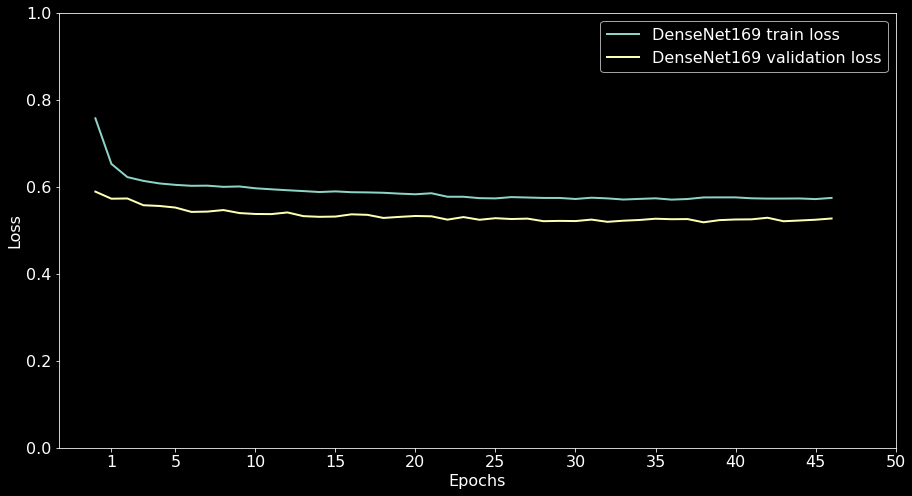

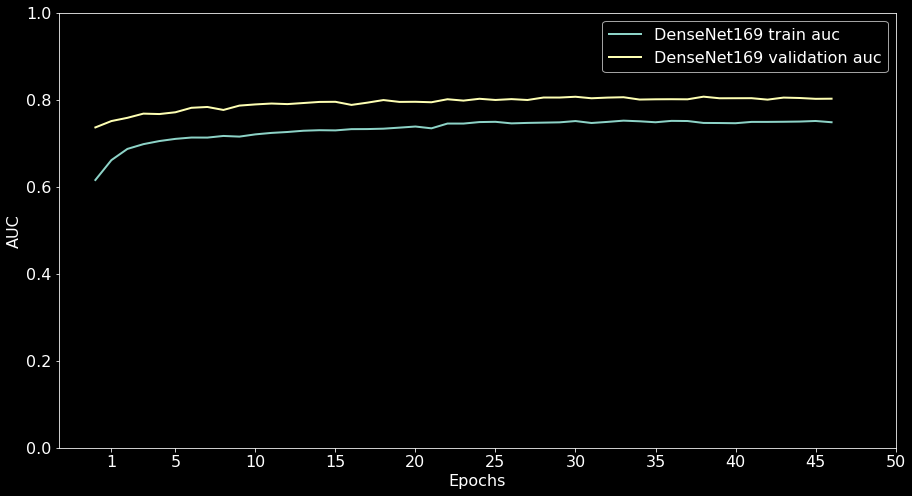

In [136]:
print("Train Loss     : {0:.5f}".format(history2.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history2.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(model2_eval[0]))
print("---")
print("Train AUC     : {0:.5f}".format(history1.history['auc'][-1]))
print("Validation AUC: {0:.5f}".format(history1.history['val_auc'][-1]))
print("Test AUC      : {0:.5f}".format(model2_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'DenseNet169': history2}, epochs=50, metric='loss')
plot_history(hs={'DenseNet169': history2}, epochs=50, metric='auc')

In [63]:
# Predict class probabilities on test set
test_generator.reset()
predictions_model2 = model2.predict(test_generator, verbose=1)

139/139 [==============================] - 84s 606ms/step


In [134]:
# Get Classification Results
df_results_model2 = get_model_results(predictions_model2)


Class Labels:  {'0': 0, '1': 1} 

Classification Report (majority_rules):

              precision    recall  f1-score   support

Negative (0)       0.70      0.93      0.80       661
Positive (1)       0.85      0.52      0.64       538

    accuracy                           0.74      1199
   macro avg       0.78      0.72      0.72      1199
weighted avg       0.77      0.74      0.73      1199
 

Confusion Matrix (majority_rules):

[[612  49]
 [259 279]] 

Kappa score: 0.4612069342842052 

Classification Report (majority_threshold):

              precision    recall  f1-score   support

Negative (0)       0.71      0.92      0.80       661
Positive (1)       0.84      0.53      0.65       538

    accuracy                           0.74      1199
   macro avg       0.77      0.72      0.72      1199
weighted avg       0.77      0.74      0.73      1199
 

Confusion Matrix (majority_threshold):

[[606  55]
 [252 286]] 

Kappa score: 0.4642062284845089 

Classification Report (aver

In [65]:
# # Clean up model from memory
# clean_up(model)